
# Bitcoin Rolling-max and Rolling-min Trade Algo


Let's import some packages that will be helpful for us:

In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')


Below we can define function to read in and prepare our dataset, as well as some functions that create technical indicators.

In [2]:
def get_data(symbol, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    df_temp = pd.read_csv('data/{}.csv'.format(symbol), usecols=['Timestamp', 'Close'])
    df_temp['datetime'] = pd.to_datetime(df_temp['Timestamp'], unit='s')# change from epoch to datetime
    df_temp = df_temp.set_index('datetime')
    df_temp.drop(['Timestamp'], inplace = True, axis = 1)
    locs = df_temp.index.indexer_at_time('00:00:00')# take the same time each day
    df_temp = df_temp.iloc[locs]
    df = df.join(df_temp, how='inner')
    df['Close'].fillna(method='ffill', inplace=True)
    return df

Let's call the function and print part of the dataframe to make sure it's in an acceptable form.

In [3]:
dates = pd.date_range('2015-12-31', '2017-10-19')
symbol = 'bitstampfull2'
data = get_data(symbol, dates)

print(data.head())

             Close
2015-12-31  425.84
2016-01-01  430.89
2016-01-02  434.87
2016-01-03  433.20
2016-01-04  430.74


Now let's write some fcns to create technical indicators that we will add to our dataframe.

In [4]:
def rolling_mean(values, window):
    return values.rolling(window = window).mean()

def rolling_max(values, window):
    return values.shift(1).rolling(window = window).max()

def rolling_min(values, window):
    return values.shift(1).rolling(window = window).min()

We can call these fcns and set them as columns in our df.

In [5]:
data['RollingMean'] = rolling_mean(data['Close'], window = 15)
data['RollingMax'] = rolling_max(data['Close'], window = 15)
data['RollingMin'] = rolling_min(data['Close'], window = 15)

print(data.tail())

              Close  RollingMean  RollingMax  RollingMin
2017-10-15  5806.92  4702.834000     5652.53     4158.75
2017-10-16  5688.17  4793.901333     5806.92     4219.74
2017-10-17  5754.30  4885.666000     5806.92     4219.74
2017-10-18  5594.84  4966.792000     5806.92     4219.74
2017-10-19  5569.27  5050.594000     5806.92     4219.74


Next we will create our buy and sell signals for our trading strat.

In [6]:
data['Buy'] = np.zeros(len(data))
data['Sell'] = np.zeros(len(data))
data.loc[data['RollingMax'] < data['Close'], 'Buy'] = 1
data.loc[data['RollingMin'] > data['Close'], 'Sell'] = -1

below we can define and call a fcn to plot our stock price, technical indicators, and buy/sell signals all on one plot.

In [7]:
def plot_data_and_signals(df, cols):
    fig,ax1 = plt.subplots(figsize=(16, 8))
    ax1.plot(df[cols])
    y = ax1.get_ylim()
    ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])
    ax2 = ax1.twinx()
    ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.125],[0.9,0.32]]))
    ax2.plot(df['Buy'], color='#77dd77')
    ax2.plot(df['Sell'], color='#dd4444')
    plt.show()

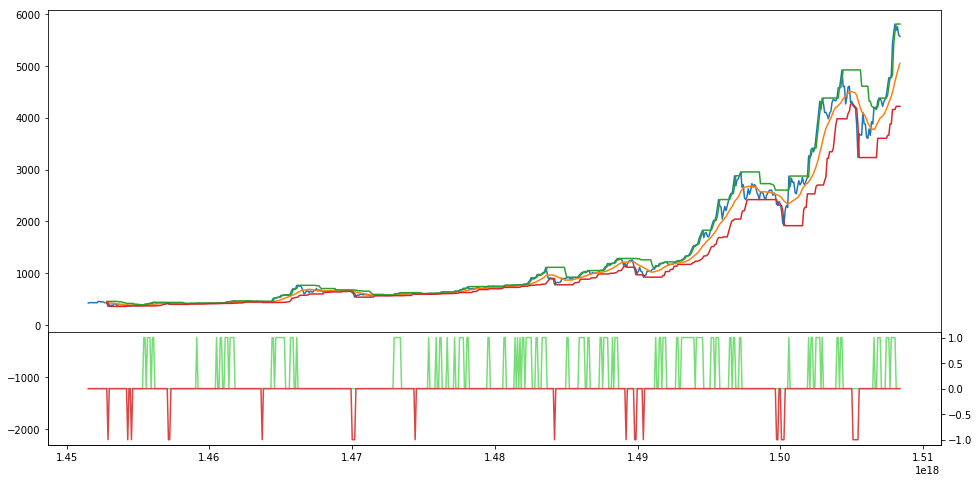

In [8]:
plot_data_and_signals(data,['Close','RollingMean','RollingMax','RollingMin'])

Lastly we can calculate our returns.

In [9]:
def calc_returns(df):
    df['Profit'] = 0
    for i in range(1, len(df)):
        if df['Buy'].iloc[i] == 1:
            df['Profit'].iloc[i] = (df['Close'].iloc[i+1] - df['Close'].iloc[i])
        if df['Sell'].iloc[i] == -1:
            df['Profit'].iloc[i] = -(df['Close'].iloc[i+1] - df['Close'].iloc[i])
    print(df['Profit'].sum())

In [10]:
calc_returns(data)

2657.52


Although we actually didn't gain as much as we would have if we just held onto our share in the beginning, this is still a fairly successful automated strategy for highly volatile stocks, like Bitcoin is in this daterange. 